In [ ]:
!pip install qiskit

In [ ]:
!pip install pennylane-qiskit

In [ ]:
!pip install requests==2.23.0

In [ ]:
!pip install Device

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

# Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/waste-classification.zip

In [7]:
from glob import glob
O_1 = glob("/content/DATASET/train/O/*.jpg")
R_1 = glob('/content/DATASET/train/R/*.jpg')

In [8]:
from sklearn.model_selection import train_test_split
O_train, O_test = train_test_split(O_1, test_size=0.20)
R_train, R_test = train_test_split(R_1, test_size=0.20)

In [9]:
!mkdir "/content/DATASET/val"

!mkdir "/content/DATASET/val/O"
files = ' '.join(O_test)
!mv -t "/content/DATASET/val/O" $files

!mkdir "/content/DATASET/val/R"
files = ' '.join(R_test)
!mv -t "/content/DATASET/val/R" $files

In [ ]:
!pip install pennylane

In [13]:
!pip install Device

In [2]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
n_qubits = 4              # Number of qubits
step = 0.0007          # Learning rate
batch_size = 4            # Number of samples for each training step
num_epochs = 1              # Number of training epochs
q_depth = 4              # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 3                # Seed for random number generator
start_time = time.time()    # Start of the computation timer

In [14]:
!pip install requests==2.23

     |████████████████████████████████| 61kB 6.2MB/s 
ERROR: device 0.1 has requirement requests==2.0.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.0.0
    Uninstalling requests-2.0.0:
      Successfully uninstalled requests-2.0.0


In [ ]:
from pennylane import Device as device
token = "5e3f9c1de36751867a463994b5aaba5f2fba10199c88e70966e523f4e6a4f3e36cd69d4ba3d576ca6506d2940e3371c532ac4482e4d05e03ac14477a56299ac8"  # Insert your personal IBM token. Remove the token when sharing your code!
dev = qml.device("qiskit.ibmq", wires=n_qubits, backend="ibmq_qasm_simulator", ibmqx_token=token, shots=1024)
dev

In [7]:
dev.shots=1024

In [8]:
dev

<IBMQDevice device (wires=4, shots=1024) at 0x7fe31fe44350>

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/DATASET"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes
print(dataset_sizes)

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}
print(class_names)
# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

{'train': 18051, 'validation': 4513}
['O', 'R']


tensor([0, 0, 0, 0])


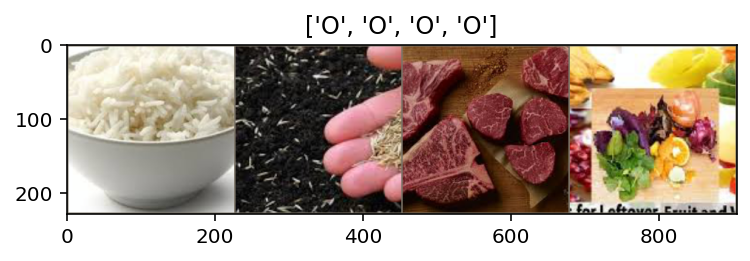

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [12]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RZ_layer(w):
    """Layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [13]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RZ_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    #exp_vals=qml.expval(qml.PauliZ(0))
    return tuple(exp_vals)

In [14]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net=nn.Linear(1664,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [15]:
model_hybrid=torchvision.models.densenet169(pretrained=True)
#model_hybrid1=torchvision.models.densenet161(pretrained=True)
for param in model_hybrid.parameters():
    param.requires_grad = False
from collections import OrderedDict
#classifier = nn.Sequential(OrderedDict([
 #                         ('fc1', nn.Linear(1664, 128)),
  #                        ('relu', nn.ReLU()),
   #                       ('fc2', DressedQuantumNet())
    #                      ]))             
model_hybrid.classifier=DressedQuantumNet()
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


In [16]:
model_hybrid

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer_hybrid = optim.Adam(model_hybrid.classifier.parameters(), lr=step)

In [19]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [20]:
dataset_sizes["train"]=1200
dataset_sizes["validation"]=400
dataset_sizes

{'train': 1200, 'validation': 400}

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                print("hello",it)
                if it==25 and phase=="train":
                  break
                if it==5 and phase=="validation":
                  break
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print("Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(phase,epoch + 1,num_epochs,it + 1,n_batches + 1,time.time() - since_batch,),end="\r")
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print("Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format("train" if phase == "train" else "validation  ",epoch + 1,num_epochs,epoch_loss,epoch_acc,))

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [24]:
import warnings 

warnings.filterwarnings('ignore')

In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=30
)

Training started:
hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
hello 8
hello 9
hello 10
hello 11
hello 12
hello 13
hello 14
hello 15
hello 16
hello 17
hello 18
hello 19
hello 20
hello 21
hello 22
hello 23
hello 24
hello 25
Phase: train Epoch: 1/30 Loss: 0.8700 Acc: 0.4700        
hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
Phase: validation   Epoch: 1/30 Loss: 0.7695 Acc: 0.4500        
hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
hello 8
hello 9


In [ ]:
torch.save(model_hybrid.state_dict(),'wts-WASTE-CLASSIFICATION-Classical-Final-results.h5')

In [21]:
model_hybrid.load_state_dict(torch.load('/content/drive/MyDrive/FYP/Final/wts-WASTE-CLASSIFICATION-quantum pauli z-Final-results.h5'))

<All keys matched successfully>

In [22]:
batch_size = 4
def test(model,dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    it=0
    for batch_idx, (data, target) in enumerate(dataloader):
        print(it)
        if it==100:
                  break
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        it+=1
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/dataset_sizes["validation"]
    epoch_loss = running_loss/dataset_sizes["validation"]
    print("acc= ",epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [23]:
import warnings 

warnings.filterwarnings('ignore')

In [24]:
k = test(model_hybrid,dataloaders["validation"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
acc=  tensor(0.8950, device='cuda:0', dtype=torch.float64) 0.3242872753739357


In [25]:
from sklearn import metrics
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('ROC-AUC:\n', metrics.roc_auc_score(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [26]:
metrics.classification_report(k[0],k[1])

'              precision    recall  f1-score   support\n\n           0       0.90      0.91      0.91       228\n           1       0.88      0.87      0.88       172\n\n    accuracy                           0.90       400\n   macro avg       0.89      0.89      0.89       400\nweighted avg       0.89      0.90      0.89       400\n'

In [27]:
performance_matrix(k[0],k[1])

Confusion Matrix:
 [[208  20]
 [ 22 150]]
ROC-AUC:
 0.8921868625050998
Precision: 89.33503836317136 Recall: 89.21868625050999, Accuracy: 89.5: ,f1_score: 89.27449628437907


In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

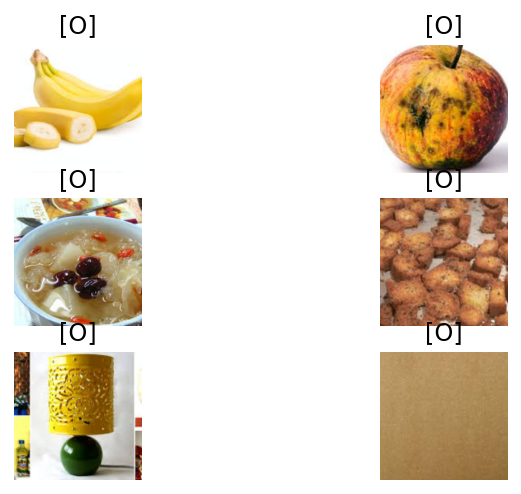

In [ ]:
visualize_model(model_hybrid)
plt.show()